In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow.compat.v1 as tf1
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

# Создание вычислительного графа

<img src='https://user-images.githubusercontent.com/54672403/83133757-fff18b00-a0eb-11ea-804b-c0784c903a4b.png' width='400'>

In [2]:
# ~~~~~~~~~~~~~ TF~v1.x 
g = tf.Graph()
# добавление узлов в граф
with g.as_default():
    a = tf1.constant(1, name='a')
    b = tf1.constant(2, name='b') 
    c = tf1.constant(3, name='c') 

    z = 2*(a-b) + c
    
# запуск графа
with tf1.Session(graph=g) as sess:
    print('2(a-b)+c ~>', sess.run(z))
    file_writer = tf1.summary.FileWriter(logdir='./logs/tf-cond/', graph=g)

2(a-b)+c ~> 1


In [3]:
# ~~~~~~~~~~~~~ TF~v2.x 
a = tf.constant(1, name='a')
b = tf.constant(2, name='b')
c = tf.constant(3, name='c')

z = 2*(a - b) + c
tf.print('2(a-b)+c ~>', z)

2(a-b)+c ~> 1


## Загрузка входных данных в модель

In [4]:
# ~~~~~~~~~~~~~ TF~v1.x 
g = tf.Graph()
with g.as_default():
    a = tf1.placeholder(shape=None, dtype=tf.int32, name='tf_a')
    b = tf1.placeholder(shape=None, dtype=tf.int32, name='tf_b')
    c = tf1.placeholder(shape=None, dtype=tf.int32, name='tf_c')
    z = 2*(a - b) + c
    
with tf1.Session(graph=g) as sess:
    feed_dict = {a:1, b:2, c:3}
    print('2(a-b)+c ~>', sess.run(z, feed_dict=feed_dict))

2(a-b)+c ~> 1


In [5]:
# ~~~~~~~~~~~~~ TF~v2.x 
def compute_z(a, b, c):
    r1 = tf.subtract(a, b)  # x-y
    r2 = tf.multiply(2, r1) # _*2
    z  = tf.add(r2, c)      # _+c
    return z

tf.print('Скалярный вход:', compute_z(1, 2, 3))
tf.print('вход ранга 1: ',  compute_z([1], [2], [3]))
tf.print('вход ранга 2:',   compute_z([[1]], [[2]], [[3]]))

Скалярный вход: 1
вход ранга 1:  [1]
вход ранга 2: [[1]]


# Переменные (Variable)

In [6]:
# ~~~~~~~~~~~~~ TF~v1.x 
g = tf.Graph()
with g.as_default():
    w = tf.Variable(np.array([[1, 2, 3, 4],[5, 6, 7, 8]]), name='w')
    print(w)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
<tf.Variable 'w:0' shape=(2, 4) dtype=int64>


In [7]:
with tf1.Session(graph=g) as sess:
    sess.run(tf1.global_variables_initializer())
    print(sess.run(w))  # !!! невозможно оценить неинициализированную переменную

[[1 2 3 4]
 [5 6 7 8]]


In [8]:
# ~~~~~~~~~~~~~ TF~v2.x 
a = tf.Variable(initial_value=    3.14,   name='var_a')
b = tf.Variable(initial_value=  [1, 2, 3],name='var_b')
c = tf.Variable(initial_value= [True, False], dtype=tf.bool)
d = tf.Variable(initial_value=   ['abc'],     dtype=tf.string)

print(a, b, c, d, sep='\n')

<tf.Variable 'var_a:0' shape=() dtype=float32, numpy=3.14>
<tf.Variable 'var_b:0' shape=(3,) dtype=int32, numpy=array([1, 2, 3], dtype=int32)>
<tf.Variable 'Variable:0' shape=(2,) dtype=bool, numpy=array([ True, False])>
<tf.Variable 'Variable:0' shape=(1,) dtype=string, numpy=array([b'abc'], dtype=object)>


In [9]:
tf.random.set_seed(123)
init = tf.keras.initializers.GlorotNormal()

tf.print(init(shape=(3,)))

[-0.58946538 -1.19845545 -0.29169783]


In [10]:
tf.print(init(shape=(2, 4)))

[[0.222344473 0.226434767 -0.433576673 -0.187390119]
 [-0.0803200901 -0.669147789 -0.0314613245 0.866858]]


# Область видимости переменной

In [11]:
g = tf.Graph()
with g.as_default(): # ~~~~~~~~~~~~~~~~~~~~~~~~~~ главный граф
    with tf1.variable_scope('net_A'): # ~~~~~~~~~~~ подсеть A
        with tf1.variable_scope('layer-1'): # ~~~~~~~ слой 1
            w1 = tf.Variable(tf1.random_normal(
                shape=(10,4)), name='weights')
        with tf1.variable_scope('layer-2'): # ~~~~~~~ слой 2
            w2 = tf.Variable(tf1.random_normal(
                shape=(20,10)), name='weights')
    
    with tf1.variable_scope('net_B'): # ~~~~~~~~~~~ подсеть B
        with tf1.variable_scope('layer-1'):
            w3 = tf.Variable(tf1.random_normal(# ~~~ слой 1
                shape=(10,4)), name='weights')

    print(w1)
    print(w2)
    print(w3)
    #tf1.summary.FileWriter(logdir='./logs/netAB/', graph=g)
    #!tensorboard --logdir=logs

<tf.Variable 'net_A/layer-1/weights:0' shape=(10, 4) dtype=float32>
<tf.Variable 'net_A/layer-2/weights:0' shape=(20, 10) dtype=float32>
<tf.Variable 'net_B/layer-1/weights:0' shape=(10, 4) dtype=float32>


# Повторное использование переменных

In [12]:
# ~~~~~~~~~~~~~~| Вспомогательные функции |~~~~~~~~~~~~~~~~ #
def build_classifier(data, labels, n_classes=2):
    data_shape = data.get_shape().as_list()
    weights = tf1.get_variable(name='weights', shape=(data_shape[1], n_classes), dtype=tf.float32)
    bias    = tf1.get_variable(name='bias',    initializer=tf.zeros(shape=n_classes))
    print(weights)
    print(bias)
    logits = tf.add(tf.matmul(data, weights), bias, name='logits')
    print(logits)
    return logits, tf.nn.softmax(logits)

def build_generator(data, n_hidden):
    data_shape = data.get_shape().as_list()
    
    w1 = tf.Variable(tf1.random_normal(shape=(data_shape[1], n_hidden)),name='w1')
    b1 = tf.Variable(        tf.zeros(shape=n_hidden),                  name='b1')
    
    hidden = tf.add(tf.matmul(data, w1), b1,  name='hidden_pre-activation')
    hidden = tf.nn.relu(hidden, 'hidden_activation')
        
    w2 = tf.Variable(tf1.random_normal(shape=(n_hidden, data_shape[1])),name='w2')
    b2 = tf.Variable(        tf.zeros(shape=data_shape[1]),             name='b2')
    output =  tf.add(        tf.matmul(hidden, w2), b2,                 name = 'output')
    return output, tf.nn.sigmoid(output)
    
# ~~~~~~~~~~~~~~| Построение графа |~~~~~~~~~~~~~~~~ #
batch_size=64
g = tf.Graph()

with g.as_default():
    tf_X = tf1.placeholder(shape=(batch_size, 100), dtype=tf.float32,    name='tf_X')
    # Построение генератора 
    with tf1.variable_scope('generator'):
        gen_out1 = build_generator(data=tf_X, n_hidden=50)
    
    # Построение классификатора
    with tf1.variable_scope('classifier') as scope:
        # классификатор для начальных данных
        cls_out1 = build_classifier(data=tf_X, labels=tf.ones(shape=batch_size))
        
        # повторное использование классификатора для сгенеритрованных данных
        scope.reuse_variables()
        cls_out2 = build_classifier(data=gen_out1[1], labels=tf.zeros(shape=batch_size))
        
        init_op = tf1.global_variables_initializer()
    tf1.summary.FileWriter(logdir='./logs/reuse/', graph=g)
        

<tf.Variable 'classifier/weights:0' shape=(100, 2) dtype=float32>
<tf.Variable 'classifier/bias:0' shape=(2,) dtype=float32>
Tensor("classifier/logits:0", shape=(64, 2), dtype=float32)
<tf.Variable 'classifier/weights:0' shape=(100, 2) dtype=float32>
<tf.Variable 'classifier/bias:0' shape=(2,) dtype=float32>
Tensor("classifier/logits_1:0", shape=(64, 2), dtype=float32)


In [13]:
g = tf.Graph()

with g.as_default():
    tf_X = tf1.placeholder(shape=(batch_size, 100), dtype=tf.float32, name='tf_X')

    # Построение генератора 
    with tf1.variable_scope('generator'):
        gen_out1 = build_generator(data=tf_X, n_hidden=50)    
        
    # Построение классификатора
    with tf1.variable_scope('classifier'):
        # классификатор для начальных данных
        cls_out1 = build_classifier(data=tf_X, labels=tf.ones(shape=batch_size))
        
    with tf1.variable_scope('classifier', reuse=True):
        # повторное использование классификатора для сгенеритрованных данных
        cls_out2 = build_classifier(data=gen_out1[1], labels=tf.zeros(shape=batch_size))
        
        init_op = tf1.global_variables_initializer()

<tf.Variable 'classifier/weights:0' shape=(100, 2) dtype=float32>
<tf.Variable 'classifier/bias:0' shape=(2,) dtype=float32>
Tensor("classifier/logits:0", shape=(64, 2), dtype=float32)
<tf.Variable 'classifier/weights:0' shape=(100, 2) dtype=float32>
<tf.Variable 'classifier/bias:0' shape=(2,) dtype=float32>
Tensor("classifier_1/logits:0", shape=(64, 2), dtype=float32)


In [14]:
g = tf.Graph()

with g.as_default():
    tf1.set_random_seed(123)
    tf_x = tf1.placeholder(shape=(None), dtype=tf.float32,  name='tf_x')
    tf_y = tf1.placeholder(shape=(None), dtype=tf.float32,  name='tf_y')
    
    # определение параметров модели (variable)
    weight = tf.Variable(tf1.random_normal(
                         shape=(1, 1), 
                         stddev=0.25),
                         name='weight')
    bias = tf.Variable(0.0, name='bias')
    
    # построение модели
    y_hat = tf.add(weight * tf_x, bias, name='y_hat')
    print(y_hat)
    
    # расчёт стоимости
    cost = tf.reduce_mean(tf.square(tf_y - y_hat), name='cost')
    print(cost)
    
    # train
    optim   = tf1.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optim.minimize(cost, name='train_op')

Tensor("y_hat:0", dtype=float32)
Tensor("cost:0", shape=(), dtype=float32)


# Linereg 1

In [15]:
np.random.seed(0)
def make_random_data():
    x, y = np.random.uniform(low=-2, high=4, size=200), []
    for t in x:
        r = np.random.normal(loc=0.0, scale=(0.5 + t*t/3), size=None)
        y.append(r)
    return  x, 1.726*x - 0.84 + np.array(y)
x, y = make_random_data() 

Эпоха    0: 10.012
Эпоха  100: 6.051
Эпоха  200: 5.071
Эпоха  300: 4.749
Эпоха  400: 4.595


 SSE: 536.1264


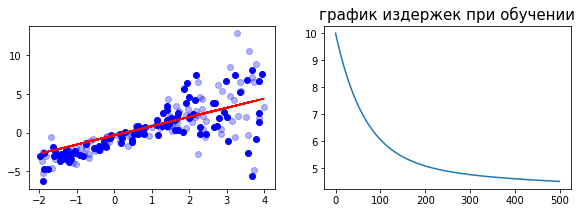

In [16]:
x_train, y_train = x[:100], y[:100]
x_test, y_test = x[100:], y[100:]

# training the model
n_epochs = 500
training_costs = []
with tf1.Session(graph=g) as sess:
    # 1. запуск инициализатора переменных
    sess.run(tf1.global_variables_initializer())
    
    # 2 итерационное обучение
    for e in range(n_epochs):
        c, _ = sess.run([cost, train_op], 
                        feed_dict={tf_x: x_train, tf_y: y_train})
        training_costs.append(c)
        if not e % 100:
            print('Эпоха %4d: %.3f' % (e, c))
    
    y_pred = sess.run('y_hat:0', feed_dict={'tf_x:0' : x_test})
print('\n\n SSE: %.4f' % (np.sum(np.square(y_pred - y_test))))


fig = plt.figure(figsize=(15, 3))
ax = fig.add_subplot(1, 3, 1)
plt.plot(x_train, y_train, 'bo')
plt.plot(x_test,  y_test, 'bo', alpha=0.3)
plt.plot(x_test,  y_pred.T[:, 0], '-r');

ax = fig.add_subplot(1, 3, 2)
plt.plot(training_costs);
plt.title('график издержек при обучении', size=15);

# Linereg 2

In [17]:
learning_rate = 0.01
training_steps = 1000

In [18]:
# определение параметров модели (variable)
W = tf.Variable(tf1.random_normal(shape=(1, 1), 
                                  stddev=0.25),
                                  name='weight')
b = tf.Variable(0.0, name='bias')
# Linear regression (Wx + b).
def linear_regression(x):
    return W * x + b

# Mean square error.
def mean_square(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true))

# Stochastic Gradient Descent Optimizer.
optimizer = tf.optimizers.SGD(learning_rate=.01)

In [19]:
# Optimization process. 
def run_optimization():
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = linear_regression(x)
        loss = mean_square(pred, y)

    # Compute gradients.
    gradients = g.gradient(loss, [W, b])
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, [W, b]))

step:     0, loss: 11.420906, W: -0.046601, b: 0.014311
step:   100, loss: 4.736052, W: 1.342311, b: -0.571149
step:   200, loss: 4.668155, W: 1.414819, b: -0.803392
step:   300, loss: 4.663901, W: 1.432928, b: -0.861538
step:   400, loss: 4.663634, W: 1.437461, b: -0.876093


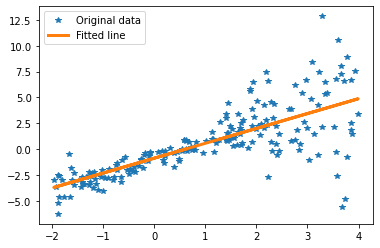

In [20]:
# Run training for the given number of steps.
for step in range(500):
    # Run the optimization to update W and b values.
    run_optimization()
    
    if step % 100 == 0:
        pred = linear_regression(x)
        loss = mean_square(pred, y)
        print("step:  %4d, loss: %f, W: %f, b: %f" % (step, loss, W.numpy(), b.numpy()))

plt.plot(x, y, '*', label='Original data')
plt.plot(x, np.array(W * x + b).T[:, 0], label='Fitted line', lw=3)
plt.legend()
plt.show()

#  Gradient
Вычисление градиентов с помощью автоматического дифференцирования и GradientTape
<br>Вычисление градиентов потерь по отношению к обучаемым переменным


In [21]:
# ~~~~~~~~~~~~~~~~~~ TF~v2.x 
w = tf.Variable(1.0)
b = tf.Variable(0.5)
print('w&b обучаемы? ', w.trainable and b.trainable)

x = tf.convert_to_tensor([1.4])
y = tf.convert_to_tensor([2.1])

with tf.GradientTape() as tape:
    z    = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

dloss_dw = tape.gradient(loss, w)
tf.print('dL/dw : ', dloss_dw)

w&b обучаемы?  True
dL/dw :  -0.559999764


In [22]:
# проверка вычисленного градиента
tf.print(* 2*x * ((w*x + b) - y))

-0.559999764


Мониторинг необучаемых тензоров с помощью `tape.watch()`

In [23]:
with tf.GradientTape() as tape:
    tape.watch(x)
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.square(y - z)

dloss_dx = tape.gradient(loss, x)
tf.print('dL/dx:', *dloss_dx)

dL/dx: -0.399999857


In [24]:
# проверка вычисленного градиента
tf.print(* 2*w * ((w*x + b) - y))

-0.399999857


Сохранение ресурсов для многократных вычислений градиента
`persistent=True`

In [25]:
with tf.GradientTape(persistent=True) as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

dloss_dw = tape.gradient(loss, w)
dloss_db = tape.gradient(loss, b)

tf.print('dL/dw:', dloss_dw)
tf.print('dL/db:', dloss_db)

dL/dw: -0.559999764
dL/db: -0.399999857


Обновление переменных через `optimizer.apply_gradients()`

In [26]:
optimizer = tf.keras.optimizers.SGD()

optimizer.apply_gradients(zip([dloss_dw, dloss_db], [w, b]))

tf.print('Обновлённый w:   ', w)
tf.print('Обновлённый bias:', b)

Обновлённый w:    1.0056
Обновлённый bias: 0.504


## Использование механики управления потоком в построении графов

In [27]:
# ~~~~~~~~~~~~~ TF~v1.x 
# !!!!!!!!_______________ ! задуманное ветвление не сработало !______________!!!!!!!!!
x, y = 1.0, 2.0
g = tf.Graph()
with g.as_default():
    tf_x = tf1.placeholder(dtype=tf.float32, shape=None, name='tf_x')
    tf_y = tf1.placeholder(dtype=tf.float32, shape=None, name='tf_y')
    if x < y:
        res = tf.add(tf_x, tf_y, name='result_add')
    else:
        res = tf.subtract(tf_x, tf_y, name='result_sub')
    print('Object: ', res)
        
with tf1.Session(graph=g) as sess:
    print('x < y:  %s ~> Result:'%(x < y), 
          res.eval(feed_dict={'tf_x:0': x, 'tf_y:0': y}))
    x, y = 2.0, 1.0
    print('x < y: %s ~> Result:'%(x < y), 
          res.eval(feed_dict={'tf_x:0': x, 'tf_y:0': y}))  
# !!!!!!!!_______________ ! задуманное ветвление не сработало !______________!!!!!!!!!

Object:  Tensor("result_add:0", dtype=float32)
x < y:  True ~> Result: 3.0
x < y: False ~> Result: 3.0


In [28]:
# ~~~~~~~~~~~~~ TF~v1.x 
x, y = 1.0, 2.0
g = tf.Graph()
with g.as_default():
    tf_x = tf1.placeholder(dtype=tf.float32, shape=None, name='tf_x')
    tf_y = tf1.placeholder(dtype=tf.float32, shape=None, name='tf_y')
    res = tf.cond(tf_x < tf_y, 
                  lambda: tf.add(tf_x, tf_y, name='result_add'),
                  lambda: tf.subtract(tf_x, tf_y, name='result_sub'))
    print('Object: ', res)
        
with tf1.Session(graph=g) as sess:
    print('x < y:  %s ~> Result:'%(x < y), 
          res.eval(feed_dict={'tf_x:0': x, 'tf_y:0': y}))
    x, y = 2.0, 1.0
    print('x < y: %s ~> Result:'%(x < y), 
          res.eval(feed_dict={'tf_x:0': x, 'tf_y:0': y})) 
    tf1.summary.FileWriter(logdir='logs/', graph=g)

Object:  Tensor("cond/Identity:0", dtype=float32)
x < y:  True ~> Result: 3.0
x < y: False ~> Result: 1.0


## Конфигурации для сети
- Keras Initializers `tf.keras.initializers`: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/initializers
- Keras Regularizers `tf.keras.regularizers:` https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/regularizers
- Activations `tf.keras.activations:` 
https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/activations

In [29]:
model = tf.keras.Sequential()

model.add(
    tf.keras.layers.Dense(
        units=16, 
        activation =       tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.GlorotNormal(),
        bias_initializer = tf.keras.initializers.Constant(2.0)
    ))

model.add(
    tf.keras.layers.Dense(
        units=32, 
        activation=        tf.keras.activations.sigmoid,
        kernel_regularizer=tf.keras.regularizers.l1
    ))

model.build(input_shape=(None, 4))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  80        
_________________________________________________________________
dense_1 (Dense)              multiple                  544       
Total params: 624
Trainable params: 624
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
  loss=     tf.keras.losses.BinaryCrossentropy(),
  metrics=[tf.keras.metrics.Accuracy(), 
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),])

# XOR classification problem

In [31]:
tf.random.set_seed(1)
np.random.seed(1)

x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1]<0] = 0

x_train = x[:100, :]
y_train = y[:100]
x_valid = x[100:, :]
y_valid = y[100:]

In [32]:
tf.random.set_seed(1)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=4, input_shape=(2,), activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.summary()

# compile:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss =    tf.keras.losses.BinaryCrossentropy(),
              metrics= [tf.keras.metrics.BinaryAccuracy()])

# train:
hist = model.fit(x_train, y_train, 
                 validation_data=(x_valid, y_valid), 
                 epochs=200, batch_size=2, verbose=0)
history = hist.history

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


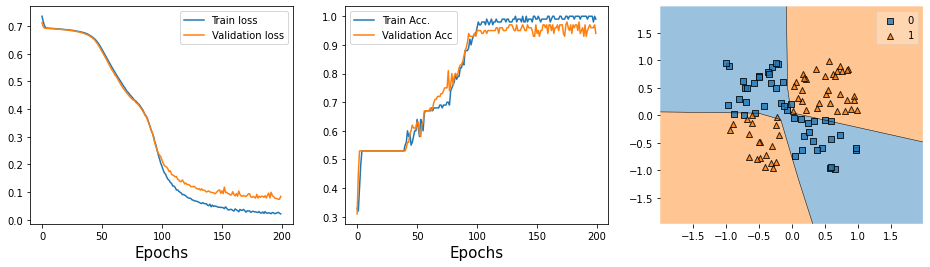

In [33]:
from mlxtend.plotting import plot_decision_regions
def creating_stat_for_model():
    fig = plt.figure(figsize=(16, 4))

    ax = fig.add_subplot(1, 3, 1)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.legend(['Train loss', 'Validation loss'])
    ax.set_xlabel('Epochs', size=15)

    ax = fig.add_subplot(1, 3, 2)
    plt.plot(history['binary_accuracy'])
    plt.plot(history['val_binary_accuracy'])
    plt.legend(['Train Acc.', 'Validation Acc'])
    ax.set_xlabel('Epochs', size=15)

    ax = fig.add_subplot(1, 3, 3)
    plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer), clf=model)
creating_stat_for_model();

## Реализация на основе класса моделей Keras
`tf.keras.Model`,
`__init__()`, `call()`

In [34]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden_1 = tf.keras.layers.Dense(units=4, activation='relu')
        self.hidden_2 = tf.keras.layers.Dense(units=4, activation='relu')
        self.hidden_3 = tf.keras.layers.Dense(units=4, activation='relu')
        self.output_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')
        
    def call(self, inputs):
        h = self.hidden_1(inputs)
        h = self.hidden_2(h)
        h = self.hidden_3(h)
        return self.output_layer(h)
    
tf.random.set_seed(1)

# testing:
model = MyModel()
model.build(input_shape=(None, 2))
model.summary()

# compile:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss =    tf.keras.losses.BinaryCrossentropy(),
              metrics= [tf.keras.metrics.BinaryAccuracy()])

## train:
hist = model.fit(x_train, y_train, 
                 validation_data=(x_valid, y_valid), 
                 epochs=200, batch_size=2, verbose=0)
history = hist.history

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              multiple                  12        
_________________________________________________________________
dense_7 (Dense)              multiple                  20        
_________________________________________________________________
dense_8 (Dense)              multiple                  20        
_________________________________________________________________
dense_9 (Dense)              multiple                  5         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


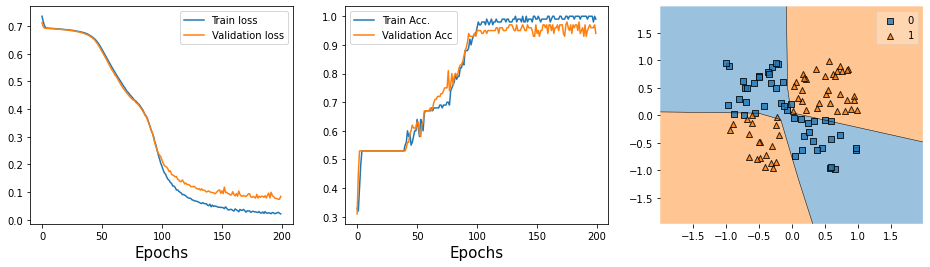

In [35]:
creating_stat_for_model()

## Написание кастомных слоев Keras
`__init__()`,` build()`,`call()`, `get_config()`

In [36]:
class NoisyLinear(tf.keras.layers.Layer):
    def __init__(self, output_dim, noise_stddev=0.1, **kwargs):
        self.output_dim = output_dim
        self.noise_stddev = noise_stddev
        super(NoisyLinear, self).__init__(**kwargs)

    def build(self, input_shape):
        self.w = self.add_weight(name = 'weights',
                                 shape = (input_shape[1], self.output_dim),
                                 initializer = 'random_normal',
                                 trainable = True)
        
        self.b = self.add_weight(shape=(self.output_dim,),
                                 initializer = 'zeros',
                                 trainable = True)

    def call(self, inputs, training=False):
        if training:
            batch = tf.shape(inputs)[0]
            dim   = tf.shape(inputs)[1]
            noise = tf.random.normal(shape=(batch, dim), mean=0.0, 
                                     stddev=self.noise_stddev)

            noisy_inputs = tf.add(inputs, noise)
        else:
            noisy_inputs = inputs
        
        z  =   tf.matmul(noisy_inputs, self.w) + self.b
        return tf.keras.activations.relu(z)
    
    def get_config(self):
        config = super(NoisyLinear, self).get_config()
        config.update({'output_dim': self.output_dim,
                     'noise_stddev': self.noise_stddev})
        return config
    
# testing:
tf.random.set_seed(1)

noisy_layer = NoisyLinear(output_dim= 4)
noisy_layer.build(input_shape= (None, 4))

x = tf.zeros(shape=(1, 4))
tf.print(noisy_layer(x, training=True))

# re-building from config:
config = noisy_layer.get_config()
new_layer = NoisyLinear.from_config(config)
tf.print(new_layer(x, training=True))

[[0 0.00821428 0 0]]
[[0 0.0108502861 0 0]]


In [37]:
tf.random.set_seed(1)
model = tf.keras.Sequential([
    NoisyLinear(output_dim=4, noise_stddev=0.1),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')])

model.build(input_shape=(None, 2))
model.summary()

# compile:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss =    tf.keras.losses.BinaryCrossentropy(),
              metrics =[tf.keras.metrics.BinaryAccuracy()])

# train:
hist = model.fit(x_train, y_train, 
                 validation_data=(x_valid, y_valid), 
                 epochs=200, batch_size=2, verbose=0)
history = hist.history

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noisy_linear_1 (NoisyLinear) multiple                  12        
_________________________________________________________________
dense_10 (Dense)             multiple                  20        
_________________________________________________________________
dense_11 (Dense)             multiple                  20        
_________________________________________________________________
dense_12 (Dense)             multiple                  5         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


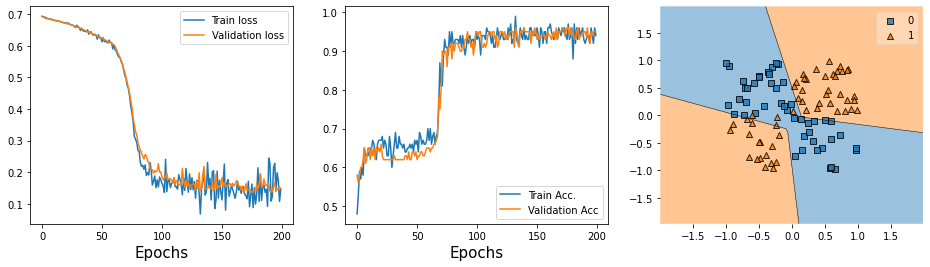

In [38]:
creating_stat_for_model()